In [1]:
# Importing packages for analyzing useses
import pandas as pd
import numpy as np

from sklearn import preprocessing, neighbors
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from numpy.linalg import *
import math
from datetime import datetime
from datetime import timedelta

In [2]:
# Import the data and making a dataframe out of it
df_deli = pd.read_csv('../Data/Delivery.csv')
df_cons = pd.read_csv('../Data/Consumption.csv')
df_info = pd.read_csv('../Data/Information.csv')
df_weather = pd.read_csv('../../Data/KNMI_Voorschoten_20170711_20190601.csv')

# Setting indexes
df_deli.set_index('ID-nummer',inplace=True)
df_deli.index = pd.to_datetime(df_deli.index)
df_deli.index.names = ['date']

df_cons.set_index('ID-nummer',inplace=True)
df_cons.index = pd.to_datetime(df_cons.index)
df_cons.index.names = ['date']

df_info.set_index('ID-nummer',inplace=True)
df_info.index.names = ['date']

df_weather.set_index('Date_and_time',inplace=True)
df_weather = df_weather.loc['2017-09-12':'2019-06-01 00:00:00']
df_weather.index = pd.to_datetime(df_weather.index)
df_weather.index.names = ['date']
df_weather = df_weather.apply(pd.to_numeric)

# Creating first row to datasets
top_row = [0 for col in df_deli.columns]
df_top_row = pd.DataFrame(top_row).transpose()

s_top_row = pd.Series([pd.to_datetime('2017-09-12 00:00:00')])
df_top_row.set_index(s_top_row, inplace=True)
df_top_row.columns = df_deli.columns

# Adding first row to the datasets
df_deli = pd.concat([df_top_row, df_deli])
df_cons = pd.concat([df_top_row, df_cons])

# Joining datasets
df_deli = df_deli.join(df_weather)
df_cons = df_cons.join(df_weather)

# Filling NaN temperature values with the previous ones
df_deli.fillna(method='ffill', inplace=True)
df_cons.fillna(method='ffill', inplace=True)

# Deleting first row (dummy row)
df_deli = df_deli.iloc[1:]
df_cons = df_cons.iloc[1:]

display(df_deli.head(2))
display(df_deli.shape)
display(df_cons.head(2))
display(df_cons.shape)

,H01,H02,H03,H04,H06,H07,H08,H09,H11,H13,...,H27,H28,H29,H31,H32,H33,T,SQ,Q,N
2017-09-12 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0


(54745, 32)

,H01,H02,H03,H04,H06,H07,H08,H09,H11,H13,...,H27,H28,H29,H31,H32,H33,T,SQ,Q,N
2017-09-12 00:15:00,0.031,0.048,0.027,0.017,0.074,0.012,0.023,0.055,0.075,0.131,...,0.096,0.025,0.024,0.299,0.027,0.022,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.037,0.023,0.034,0.015,0.069,0.024,0.020,0.036,0.071,0.088,...,0.152,0.018,0.028,0.325,0.021,0.042,14.8,0.0,0.0,7.0


(54745, 32)

## Balancing the dataset out

In [3]:
df_info.transpose()['concept'].value_counts()

WP     13
E      10
Zon     5
Name: concept, dtype: int64

In [4]:
'''df_deli = df_deli[['H01','H02','H06','H15','H29','H03','H04','H11','H23','H27','H20','H22','H25','H28','H32','T','SQ','Q','N']]
df_cons = df_cons[['H01','H02','H06','H15','H29','H03','H04','H11','H23','H27','H20','H22','H25','H28','H32','T','SQ','Q','N']]
df_info = df_info[['H01','H02','H06','H15','H29','H03','H04','H11','H23','H27','H20','H22','H25','H28','H32']]'''

"df_deli = df_deli[['H01','H02','H06','H15','H29','H03','H04','H11','H23','H27','H20','H22','H25','H28','H32','T','SQ','Q','N']]\ndf_cons = df_cons[['H01','H02','H06','H15','H29','H03','H04','H11','H23','H27','H20','H22','H25','H28','H32','T','SQ','Q','N']]\ndf_info = df_info[['H01','H02','H06','H15','H29','H03','H04','H11','H23','H27','H20','H22','H25','H28','H32']]"

In [5]:
df_deli = df_deli.groupby([df_deli.index.year, df_deli.index.month, df_deli.index.week]).agg({'H01':'sum',
                                                   'H02':'sum',
                                                   'H03':'sum',
                                                   'H04':'sum',
                                                   'H06':'sum',
                                                   'H07':'sum',
                                                   'H08':'sum',
                                                   'H09':'sum',
                                                   'H11':'sum',
                                                   'H13':'sum',
                                                   'H15':'sum',
                                                   'H16':'sum',
                                                   'H17':'sum',
                                                   'H18':'sum',
                                                   'H19':'sum',
                                                   'H20':'sum',
                                                   'H21':'sum',
                                                   'H22':'sum',
                                                   'H23':'sum',
                                                   'H24':'sum',
                                                   'H25':'sum',
                                                   'H26':'sum',
                                                   'H27':'sum',
                                                   'H28':'sum',
                                                   'H29':'sum',
                                                   'H31':'sum',
                                                   'H32':'sum',
                                                   'H33':'sum',
                                                   'T':'mean',
                                                   'SQ':'mean',
                                                   'Q':'mean',
                                                   'N':'mean',
                                                  })
df_cons = df_cons.groupby([df_cons.index.year, df_cons.index.month, df_cons.index.week]).agg({'H01':'sum',
                                                   'H02':'sum',
                                                   'H03':'sum',
                                                   'H04':'sum',
                                                   'H06':'sum',
                                                   'H07':'sum',
                                                   'H08':'sum',
                                                   'H09':'sum',
                                                   'H11':'sum',
                                                   'H13':'sum',
                                                   'H15':'sum',
                                                   'H16':'sum',
                                                   'H17':'sum',
                                                   'H18':'sum',
                                                   'H19':'sum',
                                                   'H20':'sum',
                                                   'H21':'sum',
                                                   'H22':'sum',
                                                   'H23':'sum',
                                                   'H24':'sum',
                                                   'H25':'sum',
                                                   'H26':'sum',
                                                   'H27':'sum',
                                                   'H28':'sum',
                                                   'H29':'sum',
                                                   'H31':'sum',
                                                   'H32':'sum',
                                                   'H33':'sum',
                                                   'T':'mean',
                                                   'SQ':'mean',
                                                   'Q':'mean',
                                                   'N':'mean',
                                                  })

## Dummy Variables

In [6]:
# Setting different columns (delivery, consumption, houses_info, dummy_variables)
df = pd.DataFrame(columns=['delivery','consumption', 'T', 'SQ', 'Q', 'N', 'heating_sys'])

num_houses_cols = len(df_deli.columns) - 4
# Preparing the delivery and consumption arrays
ar_deli = np.array([])
ar_cons = np.array([])
for col in range(num_houses_cols):
    ar_deli = np.append(ar_deli, df_deli.values[:, col])
    ar_cons = np.append(ar_cons, df_cons.values[:, col])

# Preparing the houses information arrays
ar_heatSystem = np.array([])
ar_spanles = np.array([])
ar_people = np.array([])
for col in df_info.columns:
    ar_heatSystem = np.append(ar_heatSystem, (df_info.loc[['concept'], [col]].values[0].tolist() * df_deli.shape[0]))
    ar_spanles = np.append(ar_spanles, (df_info.loc[['PV-aantal'], [col]].values[0].tolist() * df_deli.shape[0]))
    ar_people = np.append(ar_people, (df_info.loc[['personen'], [col]].values[0].tolist() * df_deli.shape[0]))

# Inserting the data to the dataframe
df['delivery'] = pd.Series(ar_deli)
df['consumption'] = pd.Series(ar_cons)

df['T'] = df_deli['T'].values.tolist() * num_houses_cols
df['SQ'] = df_deli['SQ'].values.tolist() * num_houses_cols
df['Q'] = df_deli['Q'].values.tolist() * num_houses_cols
df['N'] = df_deli['N'].values.tolist() * num_houses_cols

df['heating_sys'] = pd.Series(ar_heatSystem)
df['solar_panels'] = pd.Series(ar_spanles)
df['people'] = pd.Series(ar_people)

df['solar_panels'] = pd.to_numeric(df['solar_panels'])

df['sp_group'] = 0
df.loc[(df['solar_panels'] < 11), 'sp_group'] = 1
df.loc[(df['solar_panels'] >= 11) & (df['solar_panels'] <= 13), 'sp_group'] = 2
df.loc[(df['solar_panels'] > 13), 'sp_group'] = 3

# Dummy variables
dummy_sys = pd.get_dummies(df['heating_sys'], prefix='sys')
df = pd.concat([df, dummy_sys], axis=1)

print(df['heating_sys'].unique())
print(df.shape, len(ar_heatSystem))

# Replacing heating system type by numbers
df.replace('E', 1, inplace=True)
df.replace('WP', 2, inplace=True)
df.replace('Zon', 3, inplace=True)

display(df.head())
display(df.shape)

['E' 'WP' 'Zon']
(2912, 13) 2912


,delivery,consumption,T,SQ,Q,N,heating_sys,solar_panels,people,sp_group,sys_E,sys_WP,sys_Zon
0,55.321,41.008,13.008729,2.314991,44.584440,6.529412,1,17,4,3,1,0,0
1,85.880,54.068,12.614158,3.031297,51.606557,5.323398,1,17,4,3,1,0,0
2,43.201,41.659,14.022371,1.208413,31.977055,6.386233,1,17,4,3,1,0,0
3,5.711,11.680,14.200000,0.958333,26.666667,7.166667,1,17,4,3,1,0,0
4,40.955,53.301,13.708333,1.562500,30.562500,7.152778,1,17,4,3,1,0,0


(2912, 13)

In [7]:
df_info.head()

,H01,H02,H03,H04,H06,H07,H08,H09,H11,H13,...,H23,H24,H25,H26,H27,H28,H29,H31,H32,H33
date,,,,,,,,,,,,,,,,,,,,,
concept,E,E,WP,WP,E,E,E,E,WP,E,...,WP,WP,Zon,WP,WP,Zon,E,WP,Zon,WP
PV-aantal,17,14,9,11,14,13,9,14,9,15,...,11,11,13,12,9,13,14,15,12,10
personen,4,2,4,1,4,2,4,1,1,3,...,2,2,2,2,3,2,1,2,4,1


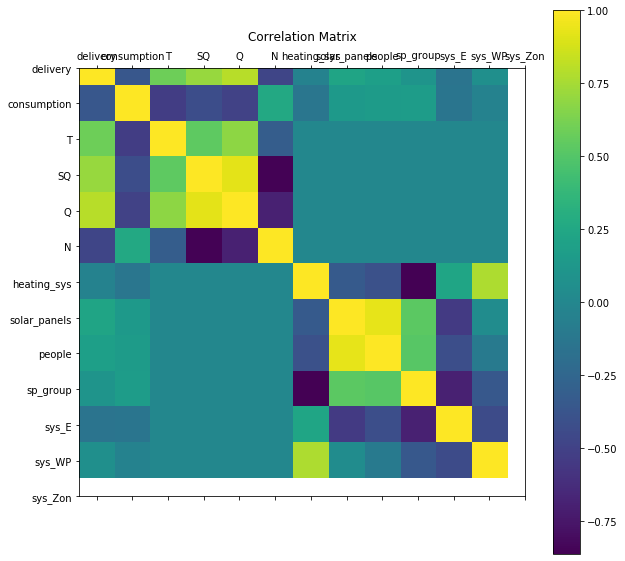

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr())
fig.colorbar(cax)

plt.title('Correlation Matrix')
ax.set_xticks(range(len(df.columns)))
ax.set_yticks(range(len(df.columns)))
ax.set_xticklabels(labels=df.columns)
ax.set_yticklabels(labels=df.columns)

plt.show()

## K Nearest Implementation (Scaler)

In [9]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve

In [10]:
features = ['delivery', 'consumption', 'T', 'SQ', 'Q', 'N']
target_feature = 'heating_sys'

X = (df[features]-df[features].min())/(df[features].max()-df[features].min())
y = df[target_feature]

In [11]:
steps = [('scaler', StandardScaler()),
        ('knn', neighbors.KNeighborsClassifier())]

pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(5, 15),
              'knn__p': np.arange(1, 3),
              'knn__weights':['uniform', 'distance']}

knn_reg = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True)
knn_reg.fit(X, y)

display(knn_reg.best_estimator_)
display('Best Params: ' + str(knn_reg.best_params_))
display('Best Score: ' + str(knn_reg.best_score_))

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=1,
           weights='distance'))])

"Best Params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}"

'Best Score: 0.6644917582417582'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn_reg.fit(X_train, y_train)
y_pred = knn_reg.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.47      0.52       200
           2       0.65      0.86      0.74       276
           3       0.69      0.36      0.47       107

   micro avg       0.63      0.63      0.63       583
   macro avg       0.64      0.56      0.58       583
weighted avg       0.63      0.63      0.62       583



In [13]:
features = ['delivery', 'consumption', 'T', 'SQ', 'Q', 'N']
target_feature = 'sp_group'

X = (df[features]-df[features].min())/(df[features].max()-df[features].min())
y = df[target_feature]

steps = [('scaler', StandardScaler()),
        ('knn', neighbors.KNeighborsClassifier())]

pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(5, 15),
              'knn__p': np.arange(1, 3),
              'knn__weights':['uniform', 'distance']}

knn_reg = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True)
knn_reg.fit(X, y)

display(knn_reg.best_estimator_)
display('Best Params: ' + str(knn_reg.best_params_))
display('Best Score: ' + str(knn_reg.best_score_))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn_reg.fit(X_train, y_train)
y_pred = knn_reg.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='distance'))])

"Best Params: {'knn__n_neighbors': 13, 'knn__p': 2, 'knn__weights': 'distance'}"

'Best Score: 0.5597527472527473'

              precision    recall  f1-score   support

           1       0.51      0.60      0.55       179
           2       0.52      0.53      0.52       236
           3       0.58      0.45      0.51       168

   micro avg       0.53      0.53      0.53       583
   macro avg       0.54      0.53      0.53       583
weighted avg       0.53      0.53      0.53       583



In [14]:
features = ['delivery', 'consumption', 'T', 'SQ', 'Q', 'N']
target_feature = 'people'

X = (df[features]-df[features].min())/(df[features].max()-df[features].min())
y = df[target_feature]

steps = [('scaler', StandardScaler()),
        ('knn', neighbors.KNeighborsClassifier())]

pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(5, 15),
              'knn__p': np.arange(1, 3),
              'knn__weights':['uniform', 'distance']}

knn_reg = GridSearchCV(pipeline, param_grid, cv=5, return_train_score=True)
knn_reg.fit(X, y)

display(knn_reg.best_estimator_)
display('Best Params: ' + str(knn_reg.best_params_))
display('Best Score: ' + str(knn_reg.best_score_))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn_reg.fit(X_train, y_train)
y_pred = knn_reg.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=1,
           weights='uniform'))])

"Best Params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}"

'Best Score: 0.4072802197802198'

              precision    recall  f1-score   support

           1       0.31      0.25      0.28       157
           2       0.32      0.46      0.38       192
           3       0.10      0.02      0.04        43
           4       0.31      0.28      0.29       191

   micro avg       0.31      0.31      0.31       583
   macro avg       0.26      0.25      0.25       583
weighted avg       0.30      0.31      0.30       583



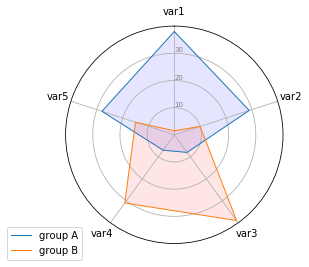

In [17]:
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
 
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
